# Acceptance map that "ruins" GENIE samples to mimic the detector

In [1]:
import sys; sys.path.insert(0, '../../'); 
from ccqe_notebook_tools import * 
from mupClassification_notebooks import *
from onbeam_offbeam_notebooks import *
%matplotlib inline

versions:
{   'OffBeam': 'prod_reco_optfilter_extbnb_v12_mcc8_dev',
    'OnBeam': 'prod_reco_optfilter_bnb_v12_unblind_mcc8',
    'Overlay': 'prodgenie_bnb_nu_uboone_overlay_mcc8.11_reco2',
    'data date': '2018_05_11',
    'date': '2018_05_11',
    'overlay date': '2018_05_11'}
OffBeam_scaling: 0.706302660161 = N(on beam)/N(off beam) before SwT
f(POT): 0.0512441465374 = N(POT on beam)/N(POT MC)


In [2]:
figures_path = '/Users/erezcohen/Desktop/Projects/uBoone/write-ups/mAextraction/Figures/acceptance/'

In [3]:
versions['data date'] = '2018_05_11'
versions['overlay date'] = '2018_05_11'
versions['Overlay'] = 'prodgenie_bnb_nu_uboone_overlay_mcc8.11_reco2'

In [4]:
OnBeam = pd.concat([pd.read_csv(vertices_files_path+'/'+versions['data date']+'/'+versions['OnBeam']+'_04_'+versions['data date']+'_vertices.csv')
                    ,pd.read_csv(vertices_files_path+'/'+versions['data date']+'/'+versions['OnBeam']+'_05_'+versions['data date']+'_vertices.csv')])
OnBeamFV = sample_in_FV(OnBeam)
print "%d"%len(OnBeam)+' pairs from On-Beam, %d'%len(OnBeamFV)+' in Fiducial Volume'; print_line()

cuts_order  = ['no cut','Chi2Proton','MatchedFlash','length','non-collinearity','vertex activity','delta phi','Pt & delta phi']
reducedOnBeam,BeamOnNumbers = apply_cuts_to_data(OnBeamFV=OnBeamFV,cuts_order=cuts_order)
print 'applied cuts to data'
selected_events = reducedOnBeam['Pt & delta phi']
print len(selected_events),'selected pairs in data'

# tight FV
max_FV_y = 104 
min_FV_z,max_FV_z = 5,1020
min_FV_x,max_FV_x = 5,240
selected_events_tightFV = sample_in_FV(sample=selected_events
                                   ,max_FV_y = max_FV_y ,min_FV_z = min_FV_z, max_FV_z = max_FV_z,min_FV_x = min_FV_x, max_FV_x = max_FV_x)
Nevents = len(selected_events_tightFV)
print Nevents,'selected pairs in data in tight FV'

38163 pairs from On-Beam, 24323 in Fiducial Volume
--------------------------------------------------------------
applied cuts to data
350 selected pairs in data
182 selected pairs in data in tight FV


In [88]:
# ----------------------------------------------------------
def find_x_poly(poly,y0,xmin=0,xmax=2):
    roots = (poly - y0).roots
    x_poly=-1
    for root in roots:
        if xmin<root and root<xmax:
            x_poly = root
    return x_poly
# ----------------------------------------------------------

# afro GENIE samples with different $m_A$

In [74]:
sns.set(style='white');
mA_array = [0.6,0.7,0.8,0.9,0.95,0.99,1.1,1.2,1.4] # S.Dytman: GENIE assumes mA=0.99 GeV/c2 (Dec-30,2017)
mA_colors= ['red','blue','forestgreen','purple','orange','pink','teal','yellow','black']

In [75]:
genie_CC1p0pi = dict()
for mA in mA_array:
    genie_sample = pd.read_csv('/Users/erezcohen/Desktop/uBoone/CCQEanalysis/mA/afro_genie_samples/CC_100k_mA_%.2f.csv'%mA)
    genie_CC1p0pi[mA] = genie_sample[genie_sample['IsCC_1p_200MeVc_0pi']==True]
    print len(genie_CC1p0pi[mA]),'CC1p0π events in GENIE samples with mA=%.2f'%mA

28507 CC1p0π events in GENIE samples with mA=0.60
30599 CC1p0π events in GENIE samples with mA=0.70
32163 CC1p0π events in GENIE samples with mA=0.80
33824 CC1p0π events in GENIE samples with mA=0.90
34543 CC1p0π events in GENIE samples with mA=0.95
34849 CC1p0π events in GENIE samples with mA=0.99
36196 CC1p0π events in GENIE samples with mA=1.10
37239 CC1p0π events in GENIE samples with mA=1.20
38810 CC1p0π events in GENIE samples with mA=1.40


# estimate the PDF of the GENIE's $Q^2$ distributions assuming a Gaussian kernel 
in order to obtain the probability distribution function for each sample and to compute the Likelihood
$$ {\displaystyle {\hat {\ell }}(\theta \,;x)={\frac {1}{n}}\sum _{i=1}^{n}\ln f(x_{i}\mid \theta ),} $$
where $f(x_{i}\mid \theta )$ is the PDF assuming the parameter $\theta$

In [76]:
var,x_label='Q2',r'$Q^2$ (GeV/c)$^2$'
Q2_cut = (0.1,0.6)
data_in_cut = selected_events_tightFV[(selected_events_tightFV['reco_Q2'] > Q2_cut[0])
                                          &(selected_events_tightFV['reco_Q2'] < Q2_cut[1])]

In [81]:
debug=0
from superplot.statslib.kde import gaussian_kde
LL_df = pd.DataFrame(columns={'mA','LL'})
log_f_i=dict()
LLmax = -1000
for mA in mA_array:
    var_array = np.array(genie_CC1p0pi[mA][var])
    weights = np.array(genie_CC1p0pi[mA]['MicroBooNEWeight_Pmu_theta_Pp_theta'])
    pdf = gaussian_kde(var_array,weights=weights)
    f = pdf(data_in_cut['reco_Q2'])    
    LL = np.sum(np.log(f))    
    if LL>LLmax: LLmax=LL    
    LL_df = LL_df.append(pd.DataFrame({'mA':mA,'LL':LL,'LL/n':LL/len(f),'-LL':-LL},index=[mA]))    
    if debug:
        print 'np.min(f):',np.min(f)
        print 'np.min(np.log(f)):',np.min(np.log(f)),'np.max(np.log(f)):',np.max(np.log(f))
        print 'LL:',LL
LL_df['-ln(L/Lmax)'] = -(LL_df['LL']-LLmax)
#     print 'done mA=%.2f'%mA
# LL_df

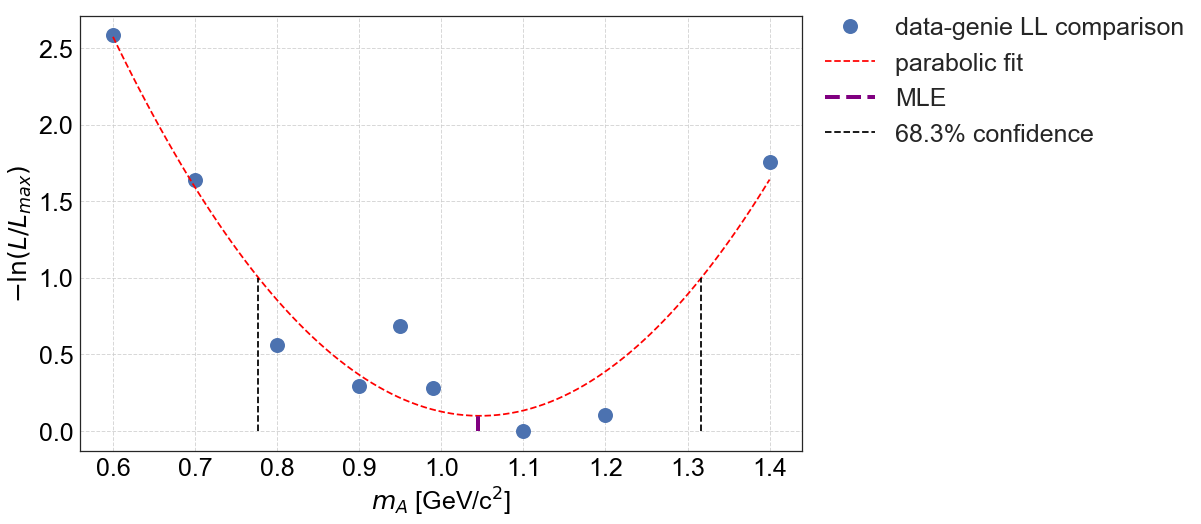

In [85]:
fig=plt.figure(figsize=(12.944,8)); ax=fig.add_subplot(1,1,1)
x,y = LL_df['mA'] , LL_df['-ln(L/Lmax)']
z = np.polyfit(x,y,deg=2)
poly = np.poly1d(z)    
plt.plot( LL_df['mA'] , LL_df['-ln(L/Lmax)'] , 'o',markersize=15
             ,linewidth=2,label='data-genie LL comparison')
x_poly = linspace(0.6,1.4,100)
plt.plot(x_poly,poly(x_poly),'--',color='red',label='parabolic fit')
    
x_MLE = find_x_poly(poly,np.min(poly(x_poly)),xmin=0.6,xmax=1.4)
plt.plot([x_MLE,x_MLE],[0,poly(x_MLE)],'--',linewidth=4,color='purple',label='MLE')
x_MLE_dw = find_x_poly(poly,1,xmin=0.6,xmax=x_MLE)
x_MLE_up = find_x_poly(poly,1,xmin=x_MLE,xmax=1.4)
plt.plot(        
        [x_MLE_dw,x_MLE_dw],[0,poly(x_MLE_dw)],'--'
        ,[x_MLE_up,x_MLE_up],[0,poly(x_MLE_up)],'--'
#        ,[x_MLE_dw,x_MLE_up],[1,1],'--'             
        ,color='black',label='68.3% confidence')
set_axes(ax,r'$m_A$ [GeV/c$^2$]','$-\ln(L/L_{max})$',do_add_grid=True)
plt.legend(bbox_to_anchor=(1.0,1.05),loc=2,fontsize=25)

# estimate the PDF of the GENIE's $p_p$ distributions assuming a Gaussian kernel 

In [86]:
var,x_label='Pp',r'$p_p$ (GeV/c)'

In [87]:
debug=0
LL_results = dict()
Pp_cut_array = [(0.2,0.9)]
for Pp_cut in Pp_cut_array:
    data_in_cut = selected_events[(selected_events['reco_Pp'] > Pp_cut[0])
                                  &(selected_events['reco_Pp'] < Pp_cut[1])]
    
    LL_df = pd.DataFrame(columns={'mA','LL'})
    LLmax = -1000
    for mA in mA_array:
        var_array = np.array(genie_CC1p0pi[mA][var])
        weights = np.array(genie_CC1p0pi[mA]['MicroBooNEWeight_Pmu_theta_Pp_theta'])
        pdf = gaussian_kde(var_array,weights=weights)
        f = pdf(data_in_cut['reco_Pp'])
        LL = np.sum(np.log(f))
        if LL>LLmax: LLmax=LL
        LL_df = LL_df.append(pd.DataFrame({'mA':mA,'LL':LL,'LL/n':LL/len(f),'-LL':-LL},index=[mA]))    
        if debug:
            print 'np.min(f):',np.min(f)
            print 'np.min(np.log(f)):',np.min(np.log(f)),'np.max(np.log(f)):',np.max(np.log(f))
            print 'LL:',LL
    # LL_df
    LL_df['-ln(L/Lmax)'] = -(LL_df['LL']-LLmax)
    LL_results['%.2f<Pp<%.2f'%(Pp_cut[0],Pp_cut[1])] = LL_df
print 'done'    

done


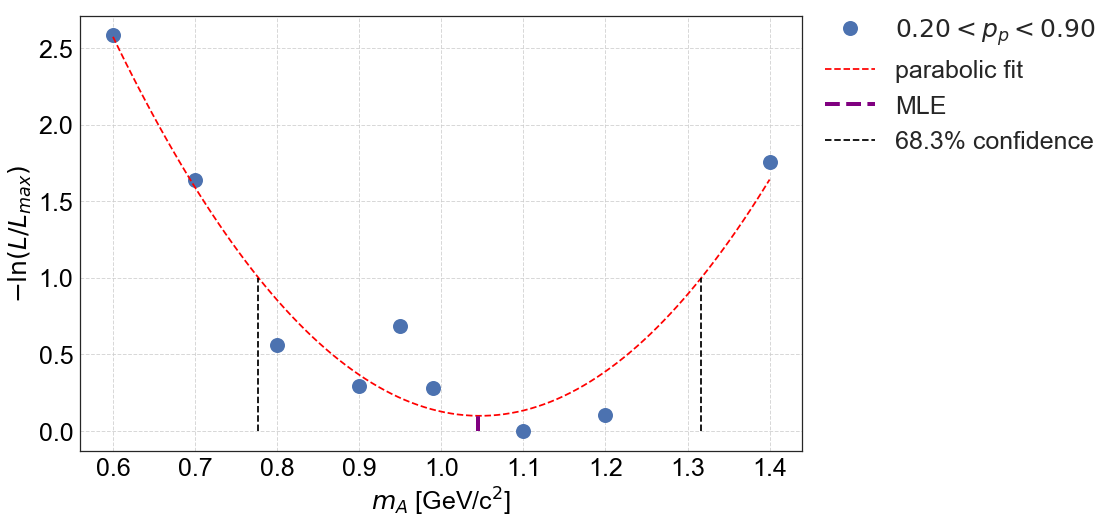

In [89]:
fig=plt.figure(figsize=(12.944,8)); ax=fig.add_subplot(1,1,1)
for Pp_cut in Pp_cut_array:
    LL_df = LL_results['%.2f<Pp<%.2f'%(Pp_cut[0],Pp_cut[1])]
    x,y = LL_df['mA'] , LL_df['-ln(L/Lmax)']
    z = np.polyfit(x,y,deg=2)
    poly = np.poly1d(z)    
    plt.plot( LL_df['mA'] , LL_df['-ln(L/Lmax)'] , 'o',markersize=15
             ,linewidth=2,label='$%.2f<p_p<%.2f$'%(Pp_cut[0],Pp_cut[1]))
    x_poly = linspace(0.6,1.4,100)
    plt.plot(x_poly,poly(x_poly),'--',color='red',label='parabolic fit')
    
    x_MLE = find_x_poly(poly,np.min(poly(x_poly)),xmin=0.6,xmax=1.4)
    plt.plot([x_MLE,x_MLE],[0,poly(x_MLE)],'--',linewidth=4,color='purple',label='MLE')
    x_MLE_dw = find_x_poly(poly,1,xmin=0.6,xmax=x_MLE)
    x_MLE_up = find_x_poly(poly,1,xmin=x_MLE,xmax=1.4)
    plt.plot(        
        [x_MLE_dw,x_MLE_dw],[0,poly(x_MLE_dw)],'--'
        ,[x_MLE_up,x_MLE_up],[0,poly(x_MLE_up)],'--'
#        ,[x_MLE_dw,x_MLE_up],[1,1],'--'             
        ,color='black',label='68.3% confidence')
set_axes(ax,r'$m_A$ [GeV/c$^2$]','$-\ln(L/L_{max})$',do_add_grid=True)
plt.legend(bbox_to_anchor=(1.0,1.05),loc=2,fontsize=25)

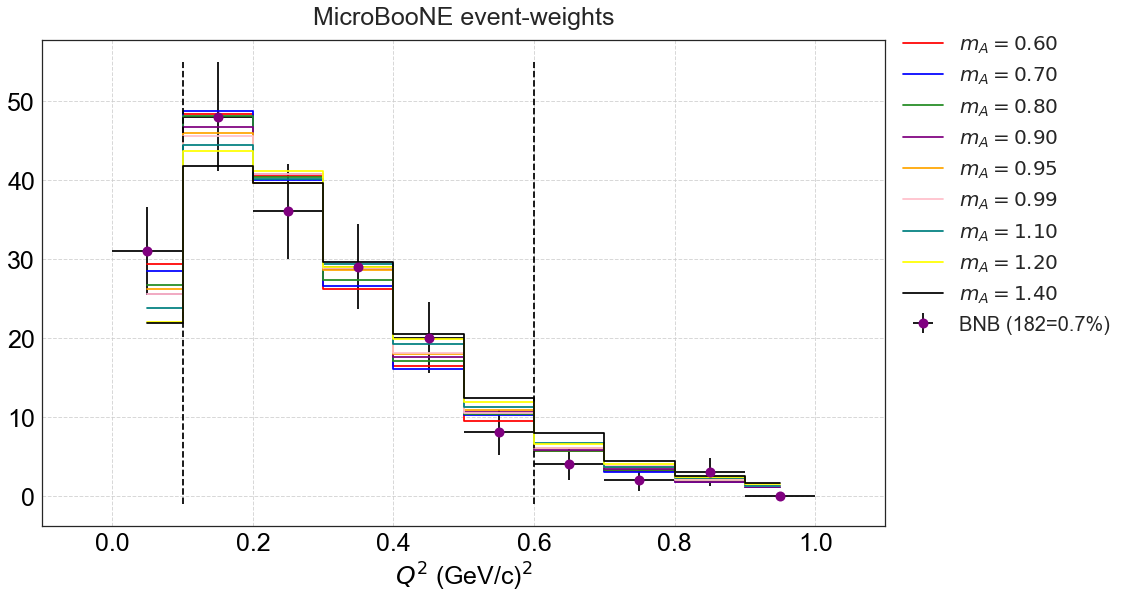

In [123]:
def add_GENIE(mA=0.99,var='Q2',bins=None,Integral_OnBeam=1,color='black',debug=0):
    hGenie,hGenie_err = np.zeros(len(bins)-1),np.zeros(len(bins)-1)
    for i in range(len(bins)-1):
        genie_in_bin = genie_CC1p0pi[mA][(genie_CC1p0pi[mA][var]>bins[i])&(genie_CC1p0pi[mA][var]<bins[i+1])]
        weights_in_bin = genie_in_bin['MicroBooNEWeight_Pmu_theta_Pp_theta']
        hGenie[i] = np.sum(weights_in_bin)
        hGenie_err[i] = np.sqrt(np.sum(np.square(weights_in_bin)))      
    hGenie_err = hGenie_err*(Integral_OnBeam/np.float(np.sum(hGenie)))    
    hGenie = hGenie*(Integral_OnBeam/np.float(np.sum(hGenie)))
    plt.step(x=mid , y=hGenie , where='mid' ,color=color, label='$m_A=%.2f$'%mA)    
    
fig=plt.figure(figsize=(12.944,8));ax=fig.add_subplot(1,1,1)
bins=linspace(0,1,11); mid=0.5*(bins[1:]+bins[:-1])
x_label=r'$Q^2$ (GeV/c)$^2$'

_,h_OnBeam = plot_OnBeam(OnBeamSample=selected_events_tightFV,var='reco_Q2',
                         OnBeamFV=OnBeamFV,markersize=10,color='purple', bins=bins, ax=ax)
h_OnBeam_err = np.array([np.max([1,np.sqrt(h_OnBeam[i])]) for i in range(len(h_OnBeam))])
Integral_OnBeam = np.float(len(selected_events_tightFV)) # 100 #
for mA,color in zip(mA_array,mA_colors):#[0.9,0.95,0.99,1.1]
    add_GENIE(mA=mA,Integral_OnBeam=Integral_OnBeam,bins=bins,color=color,debug=0 if mA==0.99 else 0)
    if mA==0.99:
        ylim = (np.min(h_OnBeam-h_OnBeam_err),np.max(h_OnBeam+h_OnBeam_err))
        plt.plot([Q2_cut[0],Q2_cut[0]],ylim,'--',[Q2_cut[1],Q2_cut[1]],ylim,'--',color='black')
set_axes(ax,x_label,'',do_add_grid=True,title='MicroBooNE event-weights')
plt.legend(bbox_to_anchor=(1.,1.05),loc=2,fontsize=20)

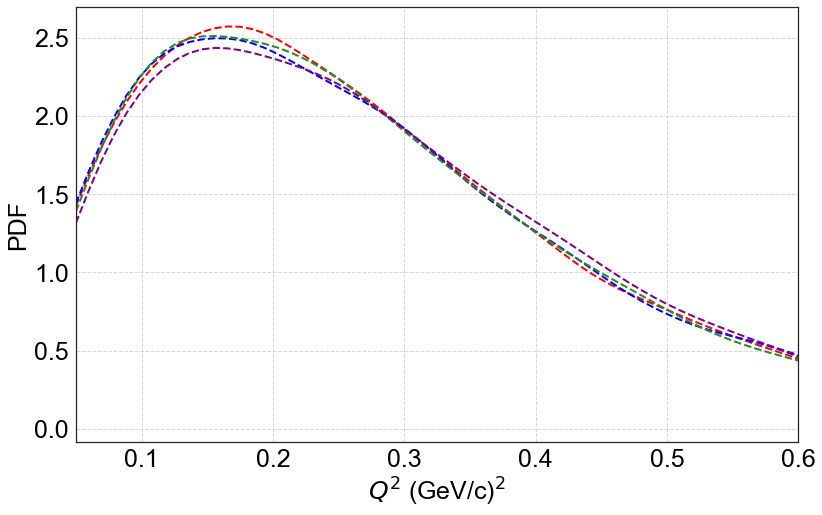

In [68]:
fig=plt.figure(figsize=(12.944,8)); ax=fig.add_subplot(1,1,1)
for mA,color in zip([0.9,0.95,0.99,1.1] #mA_array
                    ,mA_colors):
    var_array = np.array(genie_CC1p0pi[mA][var])
    weights = np.array(genie_CC1p0pi[mA]['MicroBooNEWeight_Pmu_theta_Pp_theta'])
    pdf = gaussian_kde(var_array,weights=weights)
    x_poly = linspace(0.05,1,100); dx=(x_poly[1]-x_poly[0]);
    ax.plot(x_poly, pdf(x_poly), '--',color=color,linewidth=2)

#     pdf_nw = gaussian_kde(var_array,weights=None
#     ax.plot(x_poly, pdf_nw(x_poly), '--',color='black',linewidth=2)
#     ax.hist(genie_CC1p0pi[mA]['Q2'],bins=100,histtype='step',color='blue',linewidth=2,normed=1)
#     ax.hist(genie_CC1p0pi[mA]['Q2'],weights=genie_CC1p0pi[mA]['MicroBooNEWeight_Pmu_theta_Pp_theta'],bins=100,histtype='step',color='purple',linewidth=2,normed=1)


set_axes(ax,x_label,'PDF',do_add_grid=True,xlim=(0.05,0.6))

KeyError: 0.6

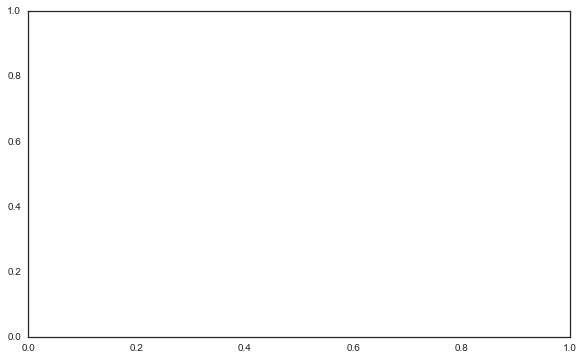

In [12]:
fig,ax=plt.subplots(figsize=(9.708,6))
for mA,c in zip(mA_array,mA_colors):
    h,_,_=plt.hist(log_f_i[mA],bins=linspace(-10,1,10),histtype='step',linewidth=3,color=c)
    print 'np.sum(h):',np.sum(h)
    plt.plot([0,0],[0,0],linewidth=3,color=c,label=r'$m_A=%.2f$'%mA)
set_axes(ax,r'$\ln (f_i)$','',do_add_legend=True,legend_loc='upper left',fontsize=20)    

def find_Q2_bin( Q2, h, bins):
    for Q2_bin in range(len(bins)-1):
        if (Q2>bins[Q2_bin])&(Q2<bins[Q2_bin+1]):
            return Q2_bin
    return -1

# KS-test results

In [126]:
from scipy.stats import ks_2samp
data = data_in_cut['reco_Q2']
mc = np.array(genie_CC1p0pi[mA]['Q2'])
D,Pval = ks_2samp(data, mc)
print "D,Pval:",D,Pval

D,Pval: 0.247146399718 4.82982934026e-08
